# Problem Sheet 3 PDS

## Pre-Amble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import pandas as pd
from scipy.special import gamma
from scipy.stats import chi2, norm, multivariate_normal

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

## Class Feedback

2. Model is

$$\delta(x) = N(x;\mu,\sigma)\alpha + \beta $$

Of course with constraints which are determined by how the system is modelled (e.g. underlying physical model), hence aren't parameters.

Note online we see that sometimes they say n.dof = n.datapts - n.params - 1; this is for a normalised (i.e the bins all sum to 1) distributed (where you lose a degree of freedom).

Because if not normalised then we just have

$$\delta(x) = N(x;\mu,\sigma)\alpha + 1- \alpha $$

If you view with this different persepective, you should still get 21.

3. You found the chi2 well; just note the addend is $(Mean(obs) - Mean(expec))^2/Variance(expec)$ because you want the 'Z-score squared' of each bin in the context of the hypothesised model. Futher discussion: when you have an incredibly complicated, you may sometimes use the observed variance.

The degree of freedom in the first chi2 test should actually be 8, not 9 (?). The chi2 and p were 3.25 and 0.92 in the second case. Correct to say that background can't explain.

5.

define n2ll to give log likelihood as a function of gam, r, delta

Matt also found undercoverage for 5.c.

For 5.d., use Feldman-Cousins

6.

"N different outcomes possible, i.e. bins (like speed ranges for a particle, colours of light you could see). But crucially you don't want the bins to be exclusive, i.e. you can see blue and red.

bi is exp no. of background, si is the theoretical number of signal values, d_i is what you actually see

H0 lambda is b_i
H1 lambda is b_i + s_i

Use the log likelihood; you must assume independence so you can multiply the likelihoods.

L1/L0 = prod (Poiss(di; si+bi)) / prod (Poiss(di; bi))

## Question 1.d.

In [2]:
def rej_sample(pdf, n, lim, max_jobs=1e6):
    """Generates a random sample from any given distribution using rejection sampling.

    Args:
        pdf (function): returns the value of the pdf of the distribution given a float input. Need not be normalised, just nonnegative.
        n (int): number of samples to realise.
        lim (tuple): gives the support of the pdf in the form (a,b).
    """
    a, b = lim
    x_vals = np.linspace(a,b,1001)
    y_max = np.max(np.vectorize(pdf)(x_vals))
    sample = []
    jobs = 0
    while len(sample) < n and jobs < max_jobs:
        x = np.random.uniform(a, b)
        y = np.random.uniform(0, y_max)
        if y < pdf(x):
            sample.append(x)
        jobs += 1
    return sample, jobs

In [3]:
def compute_d_value(k, a, b):
    return (b**k - a**k)/k

def quad_pdf(x, alpha, beta, a, b):
    N = 1/(compute_d_value(1, a, b) + alpha*compute_d_value(2, a, b) + beta*compute_d_value(3, a ,b))
    support_indicator = (x >= a)*(x <= b)
    f = N * (1 + alpha*x + beta*(x**2)) * support_indicator
    return f

In [4]:
quad_pdf_fixed = lambda x: quad_pdf(x, -1, 2, 0, 1)
quad_pdf_sample = np.array(rej_sample(quad_pdf_fixed, 10000, (0,1), max_jobs=1e10)[0])

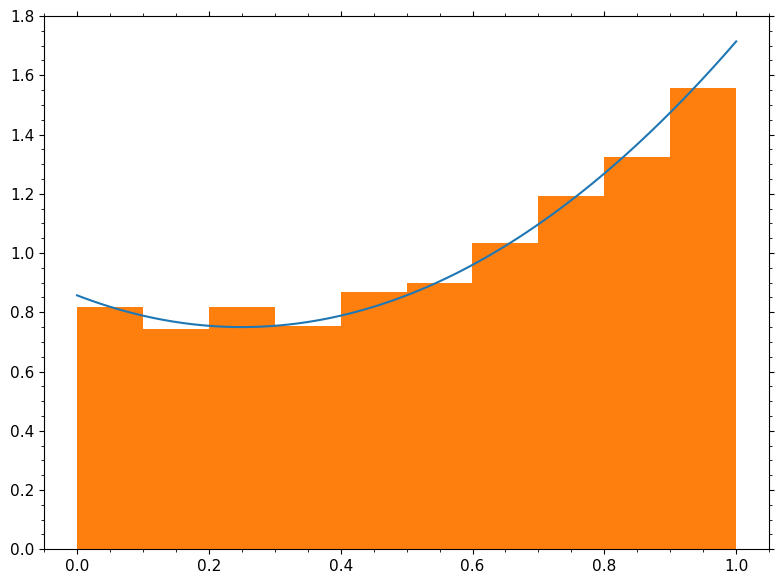

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()

x_plot = np.linspace(0,1,101)
ax.plot(x_plot, quad_pdf_fixed(x_plot))
ax.hist(quad_pdf_sample, density=True)

plt.show()

## Question 1.e.

In [6]:
def estimate_parameters_mom(mu_1, mu_2, a, b):
    d_vals = [0]+[compute_d_value(k, a, b) for k in range(1,6)]
    alpha_hat = ((mu_1*d_vals[1] - d_vals[2])*(mu_2*d_vals[3] - d_vals[5]) + (d_vals[3] - mu_2*d_vals[1])*(mu_1*d_vals[3] - d_vals[4])) / ((mu_1*d_vals[2] - d_vals[3])*(d_vals[5] - mu_2*d_vals[3]) + (mu_2*d_vals[2] - d_vals[4])*(mu_1*d_vals[3] - d_vals[4]))
    beta_hat = (d_vals[2] - mu_1*d_vals[1] + (d_vals[3] - mu_1*d_vals[2])*alpha_hat) / (mu_1*d_vals[3] - d_vals[4])
    return alpha_hat, beta_hat

In [7]:
mu_1 = np.mean(quad_pdf_sample)
mu_2 = np.mean(quad_pdf_sample**2)
alpha_hat, beta_hat = estimate_parameters_mom(mu_1, mu_2, 0, 1)

In [8]:
model = lambda x, alpha, beta: quad_pdf(x, alpha, beta, 0, 1)
nll = cost.UnbinnedNLL(quad_pdf_sample, model )
mi  = Minuit(nll, alpha=0, beta=0)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -629.2                     │              Nfcn = 62               │
│ EDM = 2.33e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │   -0.80   │   0.14    │            │            │         │         │       │
│ 1 │ beta  │   1.77    │   0.12    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────┐
│       │  alpha   beta │
├───────┼───────────────┤
│ alpha │ 0.0186 -0.015 │
│  beta │ -0.015 0.0154 │
└───────┴───────────────┘

In [9]:
print("MLE estimates: alpha = {:.5f}; beta = {:.5f}".format(*mi.values))
print("MOM estimates: alpha = {:.5f}; beta = {:.5f}".format(alpha_hat, beta_hat))

MLE estimates: alpha = -0.80416; beta = 1.76616
MOM estimates: alpha = -0.80107; beta = 1.76289


In [10]:
N = len(quad_pdf_sample)

cov_x11 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample - mu_1) * (quad_pdf_sample - mu_1) )
cov_x12 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample - mu_1) * (quad_pdf_sample**2 - mu_2) )
cov_x22 = 1/(N*(N-1)) * np.sum( (quad_pdf_sample**2 - mu_2) * (quad_pdf_sample**2 - mu_2) )

cov_paramater_estimates = np.array( [ [cov_x11, cov_x12], [ cov_x12, cov_x22] ] )

from jacobi import propagate

theta = lambda p: np.array([ *estimate_parameters_mom(*p, 0, 1) ])

mom, mom_cov = propagate( theta, [alpha_hat, beta_hat], cov_paramater_estimates)

In [11]:
mom_cov

array([[ 5.26416215e-07, -7.92375796e-07],
       [-7.92375796e-07,  1.19278410e-06]])

## Question 3.a.

In [12]:
neutrino_df = pd.DataFrame({"Events":np.arange(10), "Intervals":np.array([1042, 860, 307, 78, 15, 3, 0, 0, 0, 1])})
neutrino_df

,Events,Intervals
0,0,1042
1,1,860
2,2,307
3,3,78
4,4,15
5,5,3
6,6,0
7,7,0
8,8,0
9,9,1


In [13]:
poisson_pdf = lambda x, param: param**x * np.exp(- param) / gamma(x+1)

In [15]:
neutrino_df["Expected_1"] = poisson_pdf(neutrino_df["Events"], 0.777103209) * 2306
chi_squared_1 = np.sum(((neutrino_df["Intervals"] - neutrino_df["Expected_1"])**2 ) / neutrino_df["Expected_1"])
print("Chi-squared/d.o.f.: ", chi_squared_1/9)
p_value_1 = 1 - chi2.cdf(chi_squared_1, 9)
print("P-value: ", p_value_1)

Chi-squared/d.o.f.:  368.1377242399481
P-value:  0.0


In [16]:
neutrino_df["Intervals_adj"] = neutrino_df["Intervals"].copy()
neutrino_df.iloc[-1,-1] = 0

In [17]:
neutrino_df["Expected_2"] = poisson_pdf(neutrino_df["Events"], 0.7735357918) * 2306
chi_squared_2 = np.sum( ((neutrino_df["Intervals_adj"] - neutrino_df["Expected_2"])**2 ) / neutrino_df["Expected_2"] )
print("Chi-squared/d.o.f.: ", chi_squared_2/9)
p_value_2 = 1 - chi2.cdf(chi_squared_2, 9)
print("P-value: ", p_value_2)

Chi-squared/d.o.f.:  0.3604574572354266
P-value:  0.9538250128893228


In [17]:
chi_squared_1, chi_squared_2

(3313.239518159533, 3.2441171151188395)

In [18]:
neutrino_df

,Events,Intervals,Expected_1,Intervals_adj,Expected_2
0,0,1042,1060.150854,1042,1063.939608
1,1,860,823.846630,860,822.995367
2,2,307,320.106930,307,318.308187
3,3,78,82.918708,78,82.074258
4,4,15,16.109098,15,15.871844
5,5,3,2.503686,3,2.455488
6,6,0,0.324270,0,0.316568
7,7,0,0.035999,0,0.034982
8,8,0,0.003497,0,0.003383
9,9,1,0.000302,0,0.000291


## Question 5

In [18]:
corr_matrix = np.array(
    [
        [1.0, -0.1, -0.05, 0.1],
        [-0.1, 1.0, 0.1, -0.05],
        [-0.05, 0.1, 1.0, 0.1],
        [0.1, -0.05, 0.1, 1.0]
    ]
)

sigma_vector = np.array([8.2, 8.4, 8.2, 8.3])

V = corr_matrix * sigma_vector * sigma_vector.reshape(-1,1)
print(V)

[[67.24  -6.888 -3.362  6.806]
 [-6.888 70.56   6.888 -3.486]
 [-3.362  6.888 67.24   6.806]
 [ 6.806 -3.486  6.806 68.89 ]]


In [19]:
def model(x, r, delt, gamm):
    mu = np.array(
        [
            r * np.cos(delt + gamm),
            r * np.sin(delt + gamm),
            r * np.cos(delt - gamm),
            r * np.sin(delt - gamm)
        ]
    )
    return np.array(multivariate_normal.pdf(x, mu, V))

nll = cost.UnbinnedNLL(np.array([[-9.3, -1.3, 5.7, 6.5]]), model )
mi  = Minuit(nll, r=1, delt=0, gamm=0)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.22                      │              Nfcn = 112              │
│ EDM = 7.99e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ r    │     9     │     6     │            │            │         │         │       │
│ 1 │ delt │    2.1    │    0.7    │            │            │         │         │       │
│ 2 │ gamm │    1.2    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────┐
│      │       r    delt    gamm │
├──────┼─────────────────────────┤
│    r │    33.3  -0.395 -0.0319 │
│ delt │  -0.395   0.456  0.0195 │
│ gamm │ -0.0319  0.0195   0.356 │
└──────┴─────────────────────────┘

In [20]:
mi.values, mi.errors

(<ValueView r=9.039415488770723 delt=2.0682689236195286 gamm=1.214068629455118>,
 <ErrorView r=5.774396484992874 delt=0.674912631548085 gamm=0.5963011724671085>)

In [21]:
mi.hesse

<bound method Minuit.hesse of <FMin algorithm='Migrad' edm=7.994250265088382e-07 edm_goal=0.0002 errordef=1.0 fval=24.21518888836931 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=112 ngrad=0 reduced_chi2=nan time=0.08090009300008205>
(Param(number=0, name='r', value=9.039415488770723, error=5.774396484992874, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='delt', value=2.0682689236195286, error=0.674912631548085, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=2, name='gamm', value=1.214068629455118, error=0.5963011724671085, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))
[[ 3.33436548e+01 -3.95019436e-01 -3.19438796e-02]
 [-3.95019436e-01  4.55507060e-01  1.9

In [22]:
-0.395/(5.77*0.67)

-0.10217543133552343

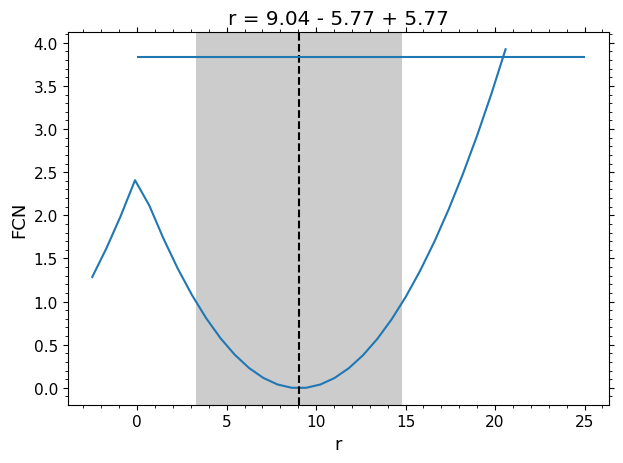

In [23]:
fig = plt.figure()
ax = plt.axes()
_ = mi.draw_mnprofile("r")
ax.hlines(norm.ppf(0.025)**2,0,25)
plt.show()

In [87]:
chi2.cdf(2.4,1)/2

0.43933237482075893

In [100]:
chi2.cdf(10,df=1)/2

0.49921729887099875

In [89]:
0.95 - 0.43933

0.51067

In [93]:
chi2.ppf(0.51067, df=1)

0.4779991939094492

In [88]:
chi2.cdf(1,1)/2

0.3413447460685429

In [26]:
r_hat, delt_hat, gamm_hat = tuple(mi.values)
r_sg, delt_sg, gamm_sg = tuple(mi.errors)
gamm_ci = (gamm_hat - gamm_sg, gamm_hat + gamm_sg)

In [27]:
gamm_hat, gamm_ci

(1.214068629455118, (0.6177674569880095, 1.8103698019222265))

In [73]:
coverage_check_sample = multivariate_normal.rvs(mean=[-9.3, -1.3, 5.7, 6.5], cov=V, size=5000, random_state=42)

In [74]:
gamma_hat_sample = []
for i in range(len(coverage_check_sample)):
    nll = cost.UnbinnedNLL(coverage_check_sample[i,:], model )
    mi  = Minuit(nll, r=10, delt=2, gamm=1)
    mi.migrad()
    gamma_hat_sample.append(mi.values[2])
gamma_hat_sample = np.array(gamma_hat_sample)
gamma_hat_sample %= np.pi

In [75]:
gamma_sample = np.arctan((coverage_check_sample[:,1] - coverage_check_sample[:,3])/(coverage_check_sample[:,0] + coverage_check_sample[:,2]))
gamma_sample %= np.pi

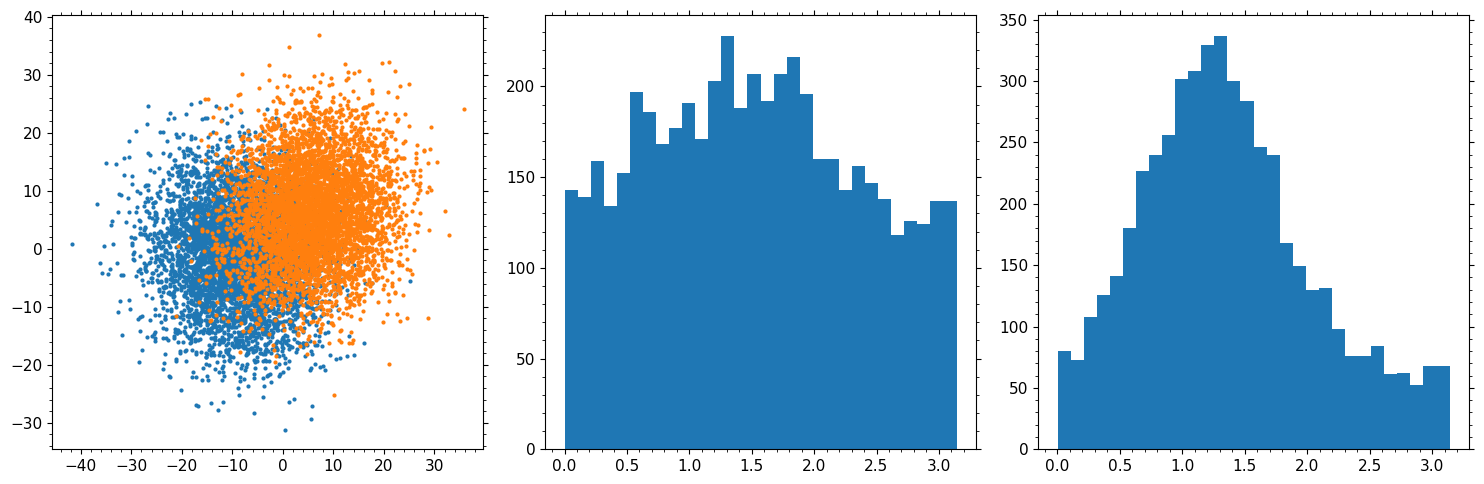

In [76]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(coverage_check_sample[:,0], coverage_check_sample[:,1], marker=".", linewidths=0.002)
ax[0].scatter(coverage_check_sample[:,2], coverage_check_sample[:,3], marker=".", linewidths=0.002)
ax[1].hist(gamma_sample, bins=30)
ax[2].hist(gamma_hat_sample, bins=30)
plt.show()

In [77]:
np.sum((gamma_sample > gamm_ci[0]) * (gamma_sample < gamm_ci[1])) / len(gamma_sample)

0.4396

In [78]:
np.sum((gamma_hat_sample > gamm_ci[0]) * (gamma_hat_sample < gamm_ci[1])) / len(gamma_hat_sample)

0.6276

In [79]:
np.mean(gamma_sample), np.std(gamma_sample)

(1.5191658864817, 0.8489343001968604)

In [80]:
chi2.cdf(1, df=3)

0.19874804309879915

In [81]:
r_within_sg = np.random.uniform(r_hat - r_sg, r_hat + r_sg, 100000)
delt_within_sg = np.random.uniform(delt_hat - delt_sg, delt_hat + delt_sg, 100000)
gamm_within_sg = np.random.uniform(gamm_hat - gamm_sg, gamm_hat + gamm_sg, 100000)

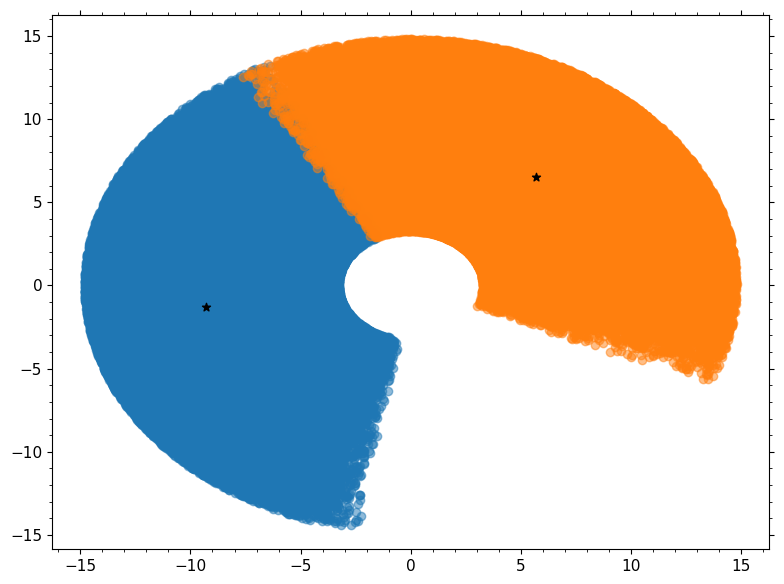

In [82]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.scatter(r_within_sg * np.cos(delt_within_sg+gamm_within_sg), r_within_sg * np.sin(delt_within_sg+gamm_within_sg), alpha=0.5)
ax.scatter(r_within_sg * np.cos(delt_within_sg-gamm_within_sg), r_within_sg * np.sin(delt_within_sg-gamm_within_sg), alpha=0.5)
ax.scatter([-9.3, 5.7], [-1.3, 6.5], marker="*", c="black")
plt.show()